In [2]:
!pip install pip==22.0.3
!pip install virtualenv
!git clone https://github.com/google/madi.git

fatal: destination path 'madi' already exists and is not an empty directory.


In [3]:
# Remove python_requires = >=3.6.* from setup.cfg

!pip install -e madi
!pip install build
!python3 -m build madi
!pip install wandb -Uq
!pip install pandas-tfrecords

print("Restart Runtime now.")

Obtaining file:///content/madi
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for madi (pyproject.toml) ... done
  Created wheel for madi: filename=madi-0.0.1-0.editable-py3-none-any.whl size=6429 sha256=db0ac1679c1cd376a50bdd8a1d61980c77bb9e864e2b5c665aae36760cd4e1e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-qsd60eye/wheels/4d/e6/39/08114827eb46c03ed955f56b9234d739b96ce8981129a1b503
Successfully built madi
  Attempting uninstall: madi
    Found existing installation: madi 0.0.1
    Uninstalling madi-0.0.1:
      Successfully uninstalled madi-0.0.1
* Creating isolated environment: virtualenv+pip...
* Installing packages in isolated environment:
  - setuptools>=40.8.0
  - wheel
* Getting build dependencies for sdist...
running egg_info
writing src/madi.egg-info/PKG-INFO
writing dependency_links to src

In [1]:
#@title Colab Imports
import sys
import time
import madi
import os
import abc
import collections
from madi.utils import file_utils
import numpy as np
import pandas as pd
from typing import Tuple, List, Mapping, Sequence, Optional
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib as mpl

import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

from scipy import signal
from scipy.fft import fftshift

import glob
from google.colab import drive

from madi.datasets import gaussian_mixture_dataset
from madi.detectors.neg_sample_neural_net_detector import NegativeSamplingNeuralNetworkAD
from madi.detectors.isolation_forest_detector import IsolationForestAd
from madi.detectors.integrated_gradients_interpreter import IntegratedGradientsInterpreter
from madi.detectors.one_class_svm import OneClassSVMAd
from madi.detectors.neg_sample_random_forest import NegativeSamplingRandomForestAd
from madi.detectors.integrated_gradients_interpreter import IntegratedGradientsInterpreter
from google.colab import drive


from absl import logging
from madi.detectors.base_detector import BaseAnomalyDetectionAlgorithm


import tensorflow as tf
assert tf.version.VERSION > '2.1.0'
from tensorflow.keras import layers, losses
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.layers import Layer, Dense, Dropout, BatchNormalization, Input, LeakyReLU

import keras
from keras import backend as K
import random

from tqdm import trange
import h5py

In [2]:
#@title Plotting utilities
def plot_attribution(df_attribution: pd.DataFrame, anomaly_score: float) -> None:
  """Plots the attribution as a pie chart.

  The center contains the anmomaly score. The wedges are ordered clockwise
  from the most blame to the least. The percentages are the normalized
  percentages (Blame(d) / Sum of Blames). The values outside the wedges
  indicate the observed value, and the expected value in parentheses.

  Args:
    df_attribution: dataframe with observed_value, expected_value, and
    attribution for each dimension.
    anomaly_score: score ranging between Normal (1) and Anomalous (0).

  """
  df_attribution = df_attribution.sort_values(by='attribution', ascending=False)
  norm = plt.Normalize()
  names=[]
  sizes = []
  sum_big = 0
  for fn, row in df_attribution.iterrows():
    # Only show the dimensions with a blame > 5%.
    if row.attribution > 0.05:
      names.append('%s\n%3.1f (%3.1f)' %(fn, row.observed_value, row.expected_value))
      wedge_size = int(100* row.attribution)
      sum_big += wedge_size
      sizes.append(wedge_size)
  names.append('other')
  sizes.append(int(100 - sum_big))

  # Create a circle for the center of the plot
  num_p_score_steps = 100
  center_color_index  = int(num_p_score_steps*anomaly_score)
  my_circle=plt.Circle( (0,0), 0.45, facecolor=plt.cm.RdYlGn(
      norm(range(num_p_score_steps+1)))[center_color_index],
      edgecolor='white', linewidth=3)

  fig, ax = plt.subplots()
  fig.set_figheight(10)
  fig.set_figwidth(10)

  center_text = "%.2f" %(anomaly_score)
  if (center_color_index < 20 ) or (center_color_index > 80):
    text_color = 'white'
  else:
    text_color = 'black'
  ax.text(0,0,center_text, fontsize=28,horizontalalignment='center',
          color=text_color, weight="bold")

  # Custom colors --> colors will cycle
  norm = plt.Normalize()
  # Choose nine colors to cycle through to show contrast between slices.
  pie_plot = plt.pie(sizes, labels=names, colors=plt.cm.RdYlBu(norm(range(9)), alpha=0.6),
                     startangle=90, counterclock=False, autopct='%1.0f%%',
                     pctdistance=0.70, textprops=
                     dict(color="black", weight="bold", fontsize=28))

  for lab in pie_plot[1]:
    lab.set_fontsize(28)
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()

def plot_gradient_series(df_grad: pd.DataFrame, delta: np.array) -> None:
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(15)
    n_points = len(df_grad)
    colors = sns.color_palette('rainbow', df_grad.shape[1])
    for ix, field_name in enumerate(df_grad):
      series_color = colors[ix]
      ig_series = (df_grad[field_name].cumsum()/float(n_points)) * delta[field_name]
      ax.plot(df_grad.index, ig_series , linewidth=3.0, linestyle='-', marker=None, color=series_color)

    ax.grid(linestyle='-', linewidth='0.5', color='darkgray')

    legend = plt.legend(loc='upper left', shadow=False, fontsize='16', bbox_to_anchor=(1, 1), labels = list(df_grad))
    legend.get_frame().set_facecolor('white')
    plt.ylabel('Cumulative Gradients')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
      item.set_fontsize(24)

    for sp in ax.spines:
       ax.spines[sp].set_color("black")
    ax.set_facecolor("white")

    plt.grid(True)
    plt.show()


def plot_pair_plots(observations):
  variables  = list(observations)
  if 'class_label' in variables:
    variables.remove('class_label')
    cell_count = len(variables) -1
  fig, ax = plt.subplots(nrows = cell_count, ncols = cell_count)

  if 'class_label' in observations.columns:

    anomalous_observations = observations[observations['class_label'] ==0]
  else:
    anomalous_observations = None

  fig.set_figheight(10 * cell_count)
  fig.set_figwidth(10* cell_count)
  rx = 1;
  for row in ax:
      y_label = variables[rx]
      cx = 0
      for col in row:
        if rx > cx:
          x_label = variables[cx]

          col.plot(observations[x_label], observations[y_label],  '.',markersize = 4.0,   color='green',  alpha=0.8)

          if anomalous_observations is not None:
            col.plot(anomalous_observations[x_label], anomalous_observations[y_label],  '.',markersize = 5.0,   color='red',  alpha=0.8)


          col.set_xlabel(x_label)
          col.set_ylabel(y_label)
        else:
          col.axis('off')
        cx = cx + 1
      rx = rx + 1



def get_single_ad_timeseries(ad: BaseAnomalyDetectionAlgorithm, observations: pd.DataFrame) -> pd.DataFrame:
  """Returns the single timeseries of predictions."""

  if 'class_label' in observations.columns:
    observations = observations.drop(columns = ['class_label'])
  return ad.predict(observations)['class_prob']



def get_ad_timeseries(ad_dict: Mapping[str,
                                       Sequence[BaseAnomalyDetectionAlgorithm]],
                      observations: pd.DataFrame) -> pd.DataFrame:
  """Returns a DF of predictions, one col for each AD."""
  preds = {}
  cols = []
  for ad_name in ad_dict:
    preds[ad_name] = get_single_ad_timeseries(ad_dict[ad_name][2], observations)
    cols.append(ad_name)
  return pd.DataFrame(preds, columns= cols)


def plot_variable_timeseries(observations, variable_name, label, predictions = None, anomaly_smoothing_kernel = 15):

  fig, ax = plt.subplots()
  ax2 = ax.twinx()
  fig.set_figheight(15)
  fig.set_figwidth(50)
  ax.tick_params(axis = 'x', labelsize = 24)
  ax.tick_params(axis = 'y', labelsize = 24)
  ax2.tick_params(axis = 'y', labelsize = 24)
  ax2.set_ylim(-0.05, 1.05)
  ax2.set_ylabel("Anomaly Score", color='red', fontsize=14)
  ax.xaxis.set_minor_locator(mdates.MinuteLocator())
  ax.xaxis.set_minor_locator(mdates.HourLocator())

  # anomalous_observations = observations[observations['class_label'] ==0]

  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

  timestamps = [ii[2] for ii in observations.index]

  ax.plot(timestamps, observations[variable_name], label = variable_name, linewidth = 1.0, marker = None, color = 'green')

  if 'class_label' in observations.columns:
    anomalous_observations = observations[observations['class_label'] ==0]
    anomalous_timestamps = [ii[2] for ii in anomalous_observations.index]
    ax.plot(anomalous_timestamps, anomalous_observations[variable_name], label = variable_name, linewidth = 1.0, marker = '.', color = 'red')


  if predictions is not None:
    for ad_name in predictions.columns:
      ad_predictions = 1 - predictions[ad_name]
      kernel_size = anomaly_smoothing_kernel
      kernel = np.ones(kernel_size) / kernel_size
      ad_smoothed = np.convolve(ad_predictions, kernel, mode='same')

      ax2.plot(timestamps, ad_predictions, label = ad_name, linewidth = 1.0, marker = None, color = 'lightgray')
      ax2.plot(timestamps, ad_smoothed, label = ad_name, linewidth = 1.0, marker = None, color = 'orange')


  for tick in ax.get_xticklabels():
    tick.set_rotation(0)


  plt.title('%s timeseries %s' %(variable_name, label), fontsize = 24)
  plt.legend(loc='lower left', fontsize = 16)
  plt.grid(True)
  plt.show()


In [3]:
# @title Utilities for Auxiliary Features


def extract_categorical_columns(flight_data: Mapping[tuple[str, str, str], tuple[str, pd.DataFrame]]) -> Mapping[str, set[str]]:
  categorical_columns = collections.defaultdict(set)
  for flight_key in flight_data:
    df = flight_data[flight_key][1].dropna()

    for col, col_type in df.dtypes.items():
      if col_type == 'object':
        categorical_columns[col].update(set(df[col]))


  return categorical_columns




class BaseAuxiliaryFeature(metaclass= abc.ABCMeta):
  """Base class for augmenting raw feature with auxiliary features."""


  @abc.abstractmethod
  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

  @property
  @abc.abstractmethod
  def feature_names(self) -> Sequence[str]:
    """Returns the name of the features."""



class TempMeanDeviationFeature(BaseAuxiliaryFeature):


  def __init__(self, ncyl = 6):
    self._FEATURE_HEADER = 'aux_avgdev'
    self._ncyl = ncyl
    self._cht_feature_names = ["CHT%d" %i for i in range(1,ncyl+1)]
    self._egt_feature_names = ["EGT%d" %i for i in range(1,ncyl+1)]



  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

    means_cht = flight_data[self._cht_feature_names].mean(axis = 1)
    means_egt = flight_data[self._egt_feature_names].mean(axis = 1)

    # CHT features
    for i, fname in enumerate(self._cht_feature_names):
      flight_data['%s_%s' %(self._FEATURE_HEADER, fname)] = flight_data[fname] - means_cht

    # EGT features
    for i, fname in enumerate(self._egt_feature_names):
      flight_data['%s_%s' %(self._FEATURE_HEADER, fname)] = flight_data[fname] - means_egt

    return flight_data


  @property
  def feature_names(self) -> Sequence[str]:
    return ['%s_%s' %(self._FEATURE_HEADER, fname) for fname in self._cht_feature_names + self._egt_feature_names]

class PcaAuxiliaryFeature(BaseAuxiliaryFeature):

  def __init__(self, training_data: pd.DataFrame, selected_features: Sequence[str], npca: int):
    self._selected_features = selected_features
    self._pca = PCA(npca, svd_solver='randomized', random_state=42)
    self._pca.fit(training_data[selected_features])
    self._feature_names = ["aux_pca_%d" %i for  i in range(npca)]


  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

    pca_trans = self._pca.transform(flight_data[self._selected_features])
    df_pca_features = pd.DataFrame(pca_trans, columns = self._feature_names, index = flight_data.index)
    return pd.concat([flight_data, df_pca_features], ignore_index = False, axis = 1)


  @property
  def feature_names(self) -> Sequence[str]:
    return self._feature_names


class PcaAuxiliaryFeature(BaseAuxiliaryFeature):

  def __init__(self, training_data: pd.DataFrame, selected_features: Sequence[str], npca: int):
    self._selected_features = selected_features
    self._pca = PCA(npca, svd_solver='randomized', random_state=42)
    self._pca.fit(training_data[selected_features])
    self._feature_names = ["aux_pca_%d" %i for  i in range(npca)]


  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

    pca_trans = self._pca.transform(flight_data[self._selected_features])
    df_pca_features = pd.DataFrame(pca_trans, columns = self._feature_names, index = flight_data.index)
    return pd.concat([flight_data, df_pca_features], ignore_index = False, axis = 1)


  @property
  def feature_names(self) -> Sequence[str]:
    return self._feature_names



class DiffPcaAuxiliaryFeature(BaseAuxiliaryFeature):

  def __init__(self, training_data: pd.DataFrame, selected_features: Sequence[str], npca: int):
    self._selected_features = selected_features
    self._pca = PCA(npca, svd_solver='randomized', random_state=42)
    self._pca.fit(training_data[selected_features])
    self._feature_names = ["aux_diffpca_%s" %col for  col in selected_features]


  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

    X = np.array(flight_data[self._selected_features])
    components = self._pca.transform(X)
    X_pca = self._pca.inverse_transform(components)
    pca_dif = X - X_pca
    df_pca_features = pd.DataFrame(pca_dif, columns = self._feature_names, index = flight_data.index)
    return pd.concat([flight_data, df_pca_features], ignore_index = False, axis = 1)


  @property
  def feature_names(self) -> Sequence[str]:
    return self._feature_names


class FourierAuxiliaryFeature(BaseAuxiliaryFeature):

  def __init__(self, selected_features: Sequence[str], num_fourier_coeffs = 4):
    self._selected_features = selected_features
    self._num_fourier_coeffs = num_fourier_coeffs
    self._feature_names = None


  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

    (n_points, n_features) = flight_data.shape
    fnames = []


    for feature in self._selected_features:

      if feature.startswith('CHT'):
        sig = flight_data[feature] -  np.mean(flight_data[['CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6']], axis = 1)
      elif feature.startswith('EGT'):
        sig = flight_data[feature] -  np.mean(flight_data[['EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6']], axis = 1)
      else:
        sig = flight_data[feature]


      _, _, Sxx = self._compute_fourier_coeffs(sig)

      (n_fourier_features, n_fourier_points) = Sxx.shape
      diff_points = n_points - n_fourier_points
      points_prepend = int(diff_points/2.0)
      points_postpend = diff_points - points_prepend
      for f in range(self._num_fourier_coeffs):
        f_array = np.concatenate([np.zeros(points_prepend), Sxx[f, :],np.zeros(points_postpend)])
        fname = 'aux_fft%d_%s' %(f, feature)
        flight_data[fname] = f_array
        fnames.append(fname)
    if self._feature_names is None:
      self._feature_names = fnames
    return flight_data


  @property
  def feature_names(self) -> Sequence[str]:
    return self._feature_names

  def _compute_fourier_coeffs(self, series: pd.Series) -> tuple[np.array, np.array, np.array]:
    fs = 1
    f, t, Sxx = signal.spectrogram(series, fs, nperseg = 256, window=('tukey', 0.5),
                                   scaling = 'spectrum', mode = 'magnitude', noverlap=255)

    # f, t, Sxx = signal.spectrogram(series, fs, nperseg = 128, window=('tukey', 0.25),
    #                                scaling = 'spectrum', mode = 'magnitude', noverlap=31)
    return f, t, Sxx


class FlightDurationAuxiliaryFeature(BaseAuxiliaryFeature):
  """Adds actual and normalized flight duration features.  """
  def __init__(self, add_normalized: bool = False, add_minutes = True):
    self._add_normalized = add_normalized
    self._add_minutes = add_minutes
    self._feature_names = {'norm': 'aux_flight_dur_norm', 'minutes':'aux_flight_dur_minutes' }
    if not add_normalized and not add_minutes:
      raise ValueError('Neither add_normalized nor add_minutes were selected.')


  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    start_time = flight_data['TIME_UTC'].min()
    end_time = flight_data['TIME_UTC'].max()
    duration_minutes =  (flight_data['TIME_UTC'] - start_time)/60.0
    duration_normalized = duration_minutes / duration_minutes.max()

    if self._add_normalized:
      flight_data[self._feature_names['norm']] = duration_normalized

    if self._add_minutes:
      flight_data[self._feature_names['minutes']] = duration_minutes

    return flight_data

  @property
  def feature_names(self) -> Sequence[str]:
    return list(self._feature_names.values())


class OneHotAuxiliaryFeature(BaseAuxiliaryFeature):
  """Class for augmenting raw feature with auxiliary features."""

  def __init__(self, categorical_columns: Mapping[str, Sequence[str]]):
    self._one_hot_cols = []
    self._categorical_cols = categorical_columns
    self._feature_names = []
    for col in categorical_columns:
      feature_names = [self._to_one_hot_column_name(col, feature) for feature in categorical_columns[col]]
      self._feature_names.extend(feature_names)

  def _to_one_hot_column_name(self, categorical_column_name: str, categorical_value: str):
    return "aux_cat_%s_%s" %(categorical_column_name, categorical_value)

  def _categorical_to_onehot(self, df_flight, column_name):

    categorical_values = self._categorical_cols[column_name]
    for categorical_value in categorical_values:
      one_hot_column_name  = self._to_one_hot_column_name(column_name, categorical_value)
      if one_hot_column_name not in self._one_hot_cols:
        self._one_hot_cols.append(one_hot_column_name)
      df_flight[one_hot_column_name] = [int(v == categorical_value) for v in df_flight[column_name]]
    return df_flight



  def append(self, flight_data: pd.DataFrame) -> pd.DataFrame:
    """Returns a new dataframe, appended with the auxiliary features."""

    for col in self._categorical_cols:
      flight_data = self._categorical_to_onehot(flight_data, col)

    return flight_data

  @property
  def feature_names(self) -> Sequence[str]:
    """Returns the name of the features."""
    return self._one_hot_cols




def apply_auxiliary_features(flights: Mapping[tuple[str,str], tuple[str, pd.DataFrame]], auxiliary_features: Mapping[str, BaseAuxiliaryFeature]):

  for flight_key in flights:
    for auxf in auxiliary_features:
      print('Adding auxiliary feature %s to flight %s' %(auxf, flight_key))
      flight_file = flights[flight_key][0]
      flight_data = flights[flight_key][1]
      flight_data = auxiliary_features[auxf].append(flight_data)
      flights[flight_key] = (flight_file, flight_data)

  return flights


In [4]:
# @title Utilities for sampling

def filter_upper_lower_quantiles(
    df_cfr: pd.DataFrame, upper_quantile: float, lower_quantile: float, select_feature_cols: Optional[str] = None
) -> pd.DataFrame:
  df_cfr_qtl = df_cfr.dropna().copy()
  upper_quantile_vals = df_cfr_qtl.quantile(q=upper_quantile)

  lower_quantile_vals = df_cfr_qtl.quantile(q=lower_quantile)

  if select_feature_cols is None:
    select_feature_cols = df_cfr_qtl.columns


  for col in select_feature_cols:
    # Ignore all columns with integer values.
    if all(isinstance(v, int) for v in df_cfr_qtl[col]):
      continue

    upper_cutoff = upper_quantile_vals[col]
    lower_cutoff = lower_quantile_vals[col]

    df_cfr_qtl[col][df_cfr_qtl[col] > upper_cutoff] = np.NaN
    df_cfr_qtl[col][df_cfr_qtl[col] < lower_cutoff] = np.NaN

  return df_cfr_qtl.dropna()

def downsample_cruise(df_flight, vspd_upper_lim: float, vspd_lower_lim: float, gnd_spd_min_lim: float, cruise_fraction: float  = 0.5) -> pd.DataFrame:

  df_cruise = df_flight[(df_flight['VSpd'] <= vspd_upper_lim) & (df_flight['VSpd'] >= vspd_lower_lim) & (df_flight['GndSpd'] >= gnd_spd_min_lim)  ]
  df_critical = df_flight[(df_flight['VSpd'] > vspd_upper_lim) | (df_flight['VSpd'] < vspd_lower_lim) | (df_flight['GndSpd'] < gnd_spd_min_lim ) ]

  print("Before downsampling: Cruise points: %d, and non-cruise points: %d" %(len(df_cruise), len(df_critical)))

  df_cruise = df_cruise.sample(n = int(len(df_critical) * cruise_fraction))

  print("After downsampling: Cruise points: %d, and non-cruise points: %d" %(len(df_cruise), len(df_critical)))

  return pd.concat([df_cruise, df_critical]).sample(frac = 1.0)



def downsample_level_flight(df_flight, vspd_upper_lim: float, vspd_lower_lim: float, pitch_upper_lim: float, pitch_lower_lim: float,  level_fraction: float  = 0.5) -> pd.DataFrame:

  df_cruise = df_flight[(df_flight['VSpd'] <= vspd_upper_lim) & (df_flight['VSpd'] >= vspd_lower_lim) & (df_flight['Pitch'] <= pitch_upper_lim) & (df_flight['Pitch'] >= pitch_lower_lim)  ]
  df_critical = df_flight[(df_flight['VSpd'] > vspd_upper_lim) | (df_flight['VSpd'] < vspd_lower_lim) & (df_flight['Pitch'] > pitch_upper_lim) | (df_flight['Pitch'] < pitch_lower_lim) ]

  print("Before downsampling: Level points: %d, and non-level points: %d" %(len(df_cruise), len(df_critical)))

  df_cruise = df_cruise.sample(n = int(len(df_critical) * level_fraction))

  print("After downsampling: Level points: %d, and non-level points: %d" %(len(df_cruise), len(df_critical)))

  return pd.concat([df_cruise, df_critical]).sample(frac = 1.0)


def drop_auxiliary_features(df_flight: pd.DataFrame, drop_features = None):

  if drop_features is None:
    drop_features = [col for col in df_flight.columns if col.startswith('aux')]

  return df_flight.drop(columns = drop_features)


def split_taxi(df_flight, gnd_spd_min_lim=30.0) -> tuple[pd.DataFrame, pd.DataFrame]:
  df_taxi = df_flight[(df_flight['GndSpd'] <= gnd_spd_min_lim) ]
  df_other = df_flight[(df_flight['GndSpd'] > gnd_spd_min_lim) ]
  print("Num taxi %d, num other %d" %(len(df_taxi), len(df_other)))
  print(df_taxi['class_label'].value_counts())
  return df_taxi, df_other

def split_ascent(df_flight, vspd_upper_lim: float,  pitch_upper_lim: float) -> pd.DataFrame:

  df_ascent = df_flight[(df_flight['VSpd'] >= vspd_upper_lim) & (df_flight['Pitch'] >= pitch_upper_lim)   ]
  df_other = df_flight[(df_flight['VSpd'] < vspd_upper_lim) | (df_flight['Pitch'] < pitch_upper_lim)   ]
  print("Num ascent %d, num other %d" %(len(df_ascent), len(df_other)))
  print(df_ascent['class_label'].value_counts())
  return df_ascent, df_other

def split_descent(df_flight, vspd_lower_lim: float,  pitch_lower_lim: float) -> pd.DataFrame:

  df_descent = df_flight[(df_flight['VSpd'] <= vspd_lower_lim) & (df_flight['Pitch'] <= pitch_lower_lim)   ]
  df_other = df_flight[(df_flight['VSpd'] > vspd_lower_lim) | (df_flight['Pitch'] > pitch_lower_lim)   ]
  print("Num descent %d, num other %d" %(len(df_descent), len(df_other)))
  print(df_descent['class_label'].value_counts())
  print(df_other['class_label'].value_counts())
  return df_descent, df_other


def split_flight_phase(df_flight: pd.DataFrame, gnd_spd_min_lim: float = 30.0,
                       vspd_upper_lim: float = 100.0,  pitch_upper_lim: float = 6,
                       vspd_lower_lim: float = -100.0,  pitch_lower_lim: float = -1):
  df_taxi, df_other = split_taxi(df_flight, gnd_spd_min_lim)
  df_ascent, df_other = split_ascent(df_other, vspd_upper_lim,  pitch_upper_lim)
  df_descent, df_cruise = split_descent(df_other, vspd_lower_lim,  pitch_lower_lim)

  return {'taxi': df_taxi, 'ascent': df_ascent, 'cruise': df_cruise, 'descent': df_descent}

def resample_flight_phase(df_flight, frac_taxi = 0.25, frac_ascent = 0.25, frac_cruise = 0.25, frac_descent = 0.25):

  assert frac_taxi + frac_ascent + frac_cruise + frac_descent == 1

  flight_phase_map = split_flight_phase(df_flight)

  N = len(df_flight)

  if len(flight_phase_map['taxi']) < N * frac_taxi:
    N = int(len(flight_phase_map['taxi'])  / frac_taxi)

  if len(flight_phase_map['ascent']) < N * frac_ascent:
    N = int(len(flight_phase_map['ascent'])  / frac_ascent)

  if len(flight_phase_map['cruise']) < N * frac_cruise:
    N = int(len(flight_phase_map['cruise'])  / frac_cruise)

  if len(flight_phase_map['descent']) < N * frac_descent:
    N = int(len(flight_phase_map['descent'])  / frac_descent)

  return pd.concat([flight_phase_map['taxi'].sample(n = int(frac_taxi * N)),
                    flight_phase_map['ascent'].sample(n = int(frac_ascent * N)),
                    flight_phase_map['cruise'].sample(n = int(frac_cruise * N)),
                    flight_phase_map['descent'].sample(n = int(frac_descent * N))]).sample(frac = 1.0)



In [5]:
#@title Mount the Google drive.
google_drive = "/drive/"
from google.colab import drive
drive.mount(google_drive, force_remount=True)


Mounted at /drive/


In [6]:
import os
import torch

# Save and Load functions for the Anomaly Transformer model
def save_model(model, optimizer, ad, fid):
    """
    Save the model's state dictionary and optimizer's state dictionary.

    Args:
        model (torch.nn.Module): The model to save.
        optimizer (torch.optim.Optimizer): The optimizer to save.
        ad (str): Identifier for the anomaly detection model.
        fid (str): Unique identifier for the model instance.
    """
    path = f"/drive/MyDrive/Models/{ad}/"
    if not os.path.exists(path):
        os.makedirs(path)

    model_path = os.path.join(path, f"{ad}_{fid}_model.pt")
    optimizer_path = os.path.join(path, f"{ad}_{fid}_optimizer.pt")

    # Save model state_dict
    torch.save(model.state_dict(), model_path)
    # Save optimizer state_dict
    torch.save(optimizer.state_dict(), optimizer_path)

def load_model(model, optimizer, ad, fid, device):
    """
    Load the model's state dictionary and optimizer's state dictionary.

    Args:
        model (torch.nn.Module): The model to load state dictionary into.
        optimizer (torch.optim.Optimizer): The optimizer to load state dictionary into.
        ad (str): Identifier for the anomaly detection model.
        fid (str): Unique identifier for the model instance.
        device (torch.device): Device to map the model to ('cpu' or 'cuda').
    """
    path = f"/drive/MyDrive/Models/{ad}/"
    model_path = os.path.join(path, f"{ad}_{fid}_model.pt")
    optimizer_path = os.path.join(path, f"{ad}_{fid}_optimizer.pt")

    if not os.path.exists(model_path) or not os.path.exists(optimizer_path):
        raise FileNotFoundError(f"Model or optimizer files not found for {ad}_{fid}.")

    # Load model state_dict
    model.load_state_dict(torch.load(model_path, map_location=device))
    # Load optimizer state_dict
    optimizer.load_state_dict(torch.load(optimizer_path, map_location=device))

    print(f"Model and optimizer loaded successfully for {ad}_{fid}.")


In [7]:
savvy_cohort_path_training = '/content/drive/MyDrive/datasets/Savvy/cohort_1/training'
savvy_cohort_path_test = '/content/drive/MyDrive/datasets/Savvy/cohort_1/test'

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
# @title Read the unlabeled training data
def read_training_data(training_dir):

  unlabeled_training_data = {}

  data_files = os.listdir(training_dir)

  for data_file in data_files:

    full_path = os.path.join(training_dir, data_file)

    splits = data_file.split('_')

    aircraft_id = splits[0]

    flight_id = splits[1]

    unlabeled_timeseries = pd.read_csv(full_path, index_col = 0, header = 0)
    unlabeled_timeseries.index = [
        (aircraft_id, flight_id, pd.Timestamp(ts))
        for ts in unlabeled_timeseries['timestamp']]

    unlabeled_training_data[(aircraft_id, flight_id)] = ['training data', unlabeled_timeseries]

    print('Loaded %s, %s with %d observations from %s.' %(aircraft_id, flight_id, len(unlabeled_timeseries), full_path))

  return unlabeled_training_data

training_data_flights = read_training_data(savvy_cohort_path_training)

Loaded 13605, 3184416 with 6462 observations from /content/drive/MyDrive/datasets/Savvy/cohort_1/training/13605_3184416_training.csv.
Loaded 13605, 4614143 with 2889 observations from /content/drive/MyDrive/datasets/Savvy/cohort_1/training/13605_4614143_training.csv.
Loaded 13605, 3604830 with 5726 observations from /content/drive/MyDrive/datasets/Savvy/cohort_1/training/13605_3604830_training.csv.
Loaded 13605, 3604846 with 5601 observations from /content/drive/MyDrive/datasets/Savvy/cohort_1/training/13605_3604846_training.csv.
Loaded 3120, 5110289 with 1979 observations from /content/drive/MyDrive/datasets/Savvy/cohort_1/training/3120_5110289_training.csv.
Loaded 4610, 3184393 with 10661 observations from /content/drive/MyDrive/datasets/Savvy/cohort_1/training/4610_3184393_training.csv.
Loaded 13605, 3844583 with 7072 observations from /content/drive/MyDrive/datasets/Savvy/cohort_1/training/13605_3844583_training.csv.
Loaded 25626, 3844571 with 5196 observations from /content/drive/

In [10]:
# @title Read the labeled test data

def read_test_data(test_dir):

  labeled_test_data = {}

  test_cases = os.listdir(test_dir)

  for test_case in test_cases:

    test_case_dir = os.path.join(test_dir, test_case)

    splits = test_case.split('_')

    aircraft_id = splits[0]

    flight_id = splits[1]

    diagnosis = pd.read_csv(os.path.join(
        os.path.join(test_case_dir, 'diagnosis.csv')),
                            index_col = 0, names = ['data'])['data']

    labeled_timeseries = pd.read_csv(
        os.path.join(os.path.join(test_case_dir, 'timeseries.csv')),
        index_col = 0, header = 0)


    labeled_timeseries.index = [(aircraft_id, flight_id, pd.Timestamp(ts)) for ts in labeled_timeseries['timestamp']]

    assert 'class_label' in labeled_timeseries

    print('Loaded %s, %s with %d observations (%s).' %(aircraft_id, flight_id,
                                                       len(labeled_timeseries), diagnosis.loc['subject']))

    labeled_test_data[(aircraft_id, flight_id)] = [
        diagnosis.loc['subject'], labeled_timeseries,
        diagnosis.loc['initial_complaint'],
        diagnosis.loc['corrective_action'],]

  return labeled_test_data


test_data_flights = read_test_data(savvy_cohort_path_test)

Loaded 2077, 6196975 with 5092 observations (Odd EGT Reading).
Loaded 3120, 4614122 with 4685 observations (Slight Engine Roughness).
Loaded 3120, 5110271 with 9322 observations (Fluctuating CHT).
Loaded 3120, 5499835 with 9169 observations (CHT 3 Oscillation).
Loaded 4406, 5078863 with 9428 observations (Brief rhythmic pattern on EGT5 toward end of flight).
Loaded 5284, 5437787 with 6670 observations (Roughness during runup and flight event).
Loaded 13530, 4885817 with 10552 observations (Abnormal rise in EGT).
Loaded 13759, 4883673 with 6558 observations (CHT #3).
Loaded 13765, 6386310 with 2422 observations (Flap Overspeed).
Loaded 21462, 4725731 with 4937 observations (Engine analysis).
Loaded 13800, 6020924 with 9258 observations (Fuel Flow Issue).
Loaded 25435, 5317124 with 11119 observations (N478KM Engine Data Analysis 06/30/2022.).


In [11]:
training_data_flights[list(training_data_flights.keys())[0]][1].columns

Index(['AtvWpt', 'LAT', 'LON', 'ALT (BARO)', 'AltMSL', 'OAT', 'IAS', 'GndSpd',
       'VSpd', 'Pitch', 'Roll', 'LatAc', 'NormAc', 'HDG', 'TRK', 'volt1',
       'volt2', 'amp1', 'FF', 'OIL_TEMP', 'OIL_PRESS', 'MAP', 'RPM', 'E1 %Pwr',
       'CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6', 'EGT1', 'EGT2', 'EGT3',
       'EGT4', 'EGT5', 'EGT6', 'AltGPS', 'TAS', 'HSIS', 'CRS', 'NAV1', 'NAV2',
       'COM1', 'COM2', 'HCDI', 'WndSpd', 'WndDr', 'WptDst', 'WptBrg', 'MagVar',
       'RollM', 'PitchM', 'RollC', 'PichC', 'VSpdG', 'GPSfix', 'HAL', 'HPLfd',
       'timestamp'],
      dtype='object')

In [11]:
#@title Augment the datasets with auxiliary features

fft_aux = FourierAuxiliaryFeature(selected_features = ['EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6', 'CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6'], num_fourier_coeffs=5)
meandev_aux = TempMeanDeviationFeature(ncyl = 6)
# auxiliary_features =  {'fft': fft_aux, 'dur': dur_aux}
auxiliary_features =  {'fft': fft_aux}
training_data_flights = apply_auxiliary_features(flights = training_data_flights, auxiliary_features = auxiliary_features)
test_data_flights = apply_auxiliary_features(flights = test_data_flights, auxiliary_features = auxiliary_features)

aux_feature_names = []
for aux_feature in auxiliary_features:
  for f in auxiliary_features[aux_feature].feature_names:
    aux_feature_names.append(f)



Adding auxiliary feature fft to flight ('13605', '3184416')
Adding auxiliary feature fft to flight ('13605', '4614143')
Adding auxiliary feature fft to flight ('13605', '3604830')
Adding auxiliary feature fft to flight ('13605', '3604846')
Adding auxiliary feature fft to flight ('3120', '5110289')
Adding auxiliary feature fft to flight ('4610', '3184393')
Adding auxiliary feature fft to flight ('13605', '3844583')
Adding auxiliary feature fft to flight ('25626', '3844571')
Adding auxiliary feature fft to flight ('13605', '3184427')
Adding auxiliary feature fft to flight ('13605', '3604758')
Adding auxiliary feature fft to flight ('25626', '3604859')
Adding auxiliary feature fft to flight ('3120', '4614105')
Adding auxiliary feature fft to flight ('25626', '3604866')
Adding auxiliary feature fft to flight ('25626', '3604771')
Adding auxiliary feature fft to flight ('3120', '5110270')
Adding auxiliary feature fft to flight ('3120', '3604803')
Adding auxiliary feature fft to flight ('3616

In [12]:
#@title Create training and test data tables
max_training_sample_size = 2000000000
use_austro = False



  # selected_columns = [
  #        'BaroA',  'OAT', 'IAS',  'VSpd', 'Pitch',
  #        'Roll', 'LatAc', 'NormAc',  'volt1',
  #         'E1_FFlow', 'E1_FPres', 'E1_OilT', 'E1_OilP', 'E1_RPM',
  #        'E1_percent_Pwr']

  # All columns
  # selected_columns = ['AtvWpt', 'LAT', 'LON', 'AltB', 'ALT (BARO)', 'AltMSL',
  #        'OAT', 'IAS', 'GndSpd', 'VSpd', 'Pitch', 'Roll', 'LatAc', 'NormAc',
  #        'HDG', 'TRK', 'volt1', 'volt2', 'amp1', 'FF', 'OIL_TEMP', 'OIL_PRESS',
  #        'MAP', 'RPM', 'E1 %Pwr', 'CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6',
  #        'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6', 'AltGPS', 'TAS', 'HSIS',
  #        'CRS', 'NAV1', 'NAV2', 'COM1', 'COM2', 'HCDI', 'WndSpd', 'WndDr',
  #        'WptDst', 'WptBrg', 'MagVar', 'RollM', 'PitchM', 'VSpdG', 'GPSfix',
  #        'HAL', 'HPLwas', 'HPLfd', 'VPLwas', 'TIME_UTC', 'timestamp']

  # selected_columns = [ 'ALT (BARO)', 'AltMSL',
  #        'OAT', 'IAS', 'GndSpd', 'VSpd', 'Pitch', 'Roll', 'LatAc', 'NormAc',
  #        'HDG', 'TRK', 'volt1', 'volt2', 'amp1', 'FF', 'OIL_TEMP', 'OIL_PRESS',
  #        'MAP', 'RPM', 'E1 %Pwr', 'CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6',
  #        'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6', 'AltGPS', 'TAS',
  #        'CRS', 'NAV1', 'NAV2', 'COM1', 'COM2', 'HCDI', 'WndSpd', 'WndDr',
  #        'WptDst', 'WptBrg', 'MagVar']

selected_columns = ['AltMSL', 'GndSpd', 'VSpd', 'Pitch', 'Roll', 'FF', 'OIL_TEMP', 'OIL_PRESS',
        'MAP', 'RPM', 'E1 %Pwr', 'CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6',
        'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6']

  # selected_columns = [ 'CHT1', 'CHT2', 'CHT3', 'CHT4', 'CHT5', 'CHT6',
  #        'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6']


def clean_flight_data(flight_log, selected_columns):
  df = flight_log[selected_columns].dropna()
  num_df = (df.drop(selected_columns, axis=1)
         .join(df[selected_columns].apply(pd.to_numeric, errors='coerce')))

  num_df = num_df[num_df[selected_columns].notnull().all(axis=1)]
  num_df['timestamp'] =  flight_log.loc[num_df.index]['timestamp']
  num_df = num_df.set_index('timestamp')
  return num_df


def check_columns(flights, selected_columns):

  for col in selected_columns:

    if col not in flights.columns:
      print("Column %s not in flight." %col)
      return False
  return True

def merge_flights(flights, selected_columns):
  merged = []

  for key in flights:
    if check_columns(flights[key][1], selected_columns):
      df = flights[key][1][selected_columns]
      merged.append(df)
    else:
      print("flight %s, %s is skipped" %(key[0], key[1]))

  merged_df = pd.concat(merged)
  return merged_df



training_sample= merge_flights(training_data_flights, selected_columns + aux_feature_names )
training_sample = training_sample.sample(n = min(len(training_sample), max_training_sample_size))

# For data shape consistensy, we'll add a dummy label, class_label = 1
# the training data.
training_sample['class_label'] = 1

test_sample= merge_flights(test_data_flights, selected_columns + aux_feature_names + ['class_label'])
test_sample = test_sample.sample(n = len(test_sample))

In [13]:
filtered_training_sample  = training_sample.copy()
filtered_training_sample = filter_upper_lower_quantiles(training_sample, upper_quantile=0.99, lower_quantile = 0.01)


<ipython-input-4-4cd53ba5ef14>:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_cfr_qtl[col][df_cfr_qtl[col] > upper_cutoff] = np.NaN
<ipython-input-4-4cd53ba5ef14>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [ ]:
filtered_test_sample = test_sample.copy()


In [ ]:

filtered_test_sample.columns


Index(['AltMSL', 'GndSpd', 'VSpd', 'Pitch', 'Roll', 'FF', 'OIL_TEMP',
       'OIL_PRESS', 'MAP', 'RPM', 'E1 %Pwr', 'CHT1', 'CHT2', 'CHT3', 'CHT4',
       'CHT5', 'CHT6', 'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6',
       'aux_fft0_EGT1', 'aux_fft1_EGT1', 'aux_fft2_EGT1', 'aux_fft3_EGT1',
       'aux_fft4_EGT1', 'aux_fft0_EGT2', 'aux_fft1_EGT2', 'aux_fft2_EGT2',
       'aux_fft3_EGT2', 'aux_fft4_EGT2', 'aux_fft0_EGT3', 'aux_fft1_EGT3',
       'aux_fft2_EGT3', 'aux_fft3_EGT3', 'aux_fft4_EGT3', 'aux_fft0_EGT4',
       'aux_fft1_EGT4', 'aux_fft2_EGT4', 'aux_fft3_EGT4', 'aux_fft4_EGT4',
       'aux_fft0_EGT5', 'aux_fft1_EGT5', 'aux_fft2_EGT5', 'aux_fft3_EGT5',
       'aux_fft4_EGT5', 'aux_fft0_EGT6', 'aux_fft1_EGT6', 'aux_fft2_EGT6',
       'aux_fft3_EGT6', 'aux_fft4_EGT6', 'aux_fft0_CHT1', 'aux_fft1_CHT1',
       'aux_fft2_CHT1', 'aux_fft3_CHT1', 'aux_fft4_CHT1', 'aux_fft0_CHT2',
       'aux_fft1_CHT2', 'aux_fft2_CHT2', 'aux_fft3_CHT2', 'aux_fft4_CHT2',
       'aux_fft0_CHT3', 'aux_fft

this is the code you should run

Epoch 1/5: 100%|██████████| 13025/13025 [10:14<00:00, 21.21it/s, loss=0.502]


Epoch 1/5, Loss: 0.502230305064205


Epoch 2/5: 100%|██████████| 13025/13025 [10:08<00:00, 21.42it/s, loss=0.316]


Epoch 2/5, Loss: 0.3161550538610817


Epoch 3/5: 100%|██████████| 13025/13025 [10:01<00:00, 21.65it/s, loss=0.294]


Epoch 3/5, Loss: 0.293929566298245


Epoch 4/5: 100%|██████████| 13025/13025 [10:05<00:00, 21.52it/s, loss=0.284]


Epoch 4/5, Loss: 0.28397520651972913


Epoch 5/5: 100%|██████████| 13025/13025 [10:01<00:00, 21.64it/s, loss=0.279]


Epoch 5/5, Loss: 0.2785903564673239


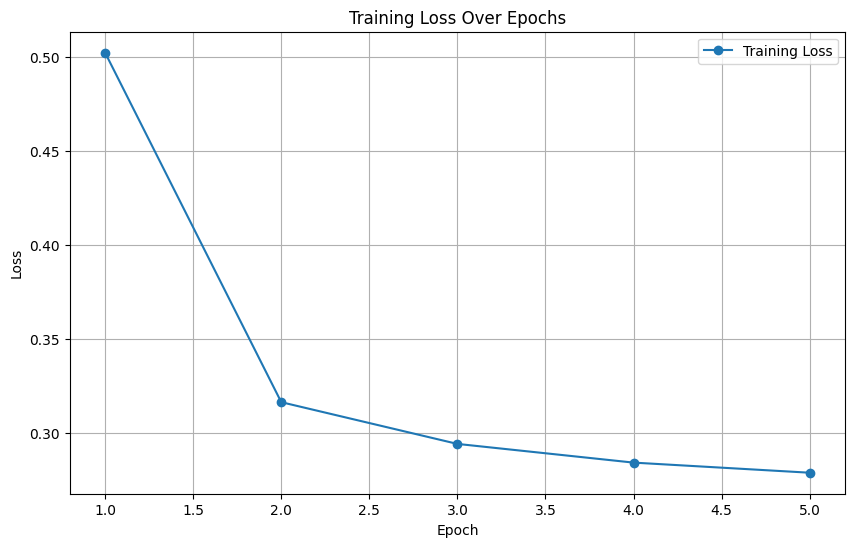

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# File paths
source_test_dir = "/content/drive/MyDrive/datasets/Savvy/GADfly_training_test_data/cohort-1/test_data/analysis flights"
test_dir = "/content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib"
source_training_dir = "/content/drive/MyDrive/datasets/Savvy/GADfly_training_test_data/cohort-1/training_data"
training_dir = "/content/drive/MyDrive/datasets/Savvy/cohort_1/training/"
labeled_training_dir = "/content/drive/MyDrive/datasets/Savvy/cohort_1/labeled_training2"

# Load data from directory

def load_data_from_directory_recursive(directory, selected_columns, fill_missing=True):
    all_files = []
    for root, _, files in os.walk(directory):
        all_files.extend([os.path.join(root, f) for f in files if f.endswith('.csv')])

    data_frames = []
    for file in all_files:
        try:
            df = pd.read_csv(file)
            common_columns = [col for col in selected_columns if col in df.columns]
            missing_columns = [col for col in selected_columns if col not in df.columns]
            if common_columns:
                df = df[common_columns]
                if fill_missing:
                    for col in missing_columns:
                        df[col] = 0
                data_frames.append(df[selected_columns])
            else:
                print(f"Skipping file {file}: No common columns found.")
        except Exception as e:
            print(f"Error loading file {file}: {e}")
    if not data_frames:
        raise ValueError("No valid data files found with the specified columns.")
    data_frames = data_frames[:60]
    return pd.concat(data_frames, ignore_index=True)

selected_columns = ['AltMSL', 'GndSpd', 'VSpd', 'Pitch', 'Roll', 'FF', 'OIL_TEMP',
                    'OIL_PRESS', 'MAP', 'RPM', 'E1 %Pwr', 'CHT1', 'CHT2', 'CHT3',
                    'CHT4', 'CHT5', 'CHT6', 'EGT1', 'EGT2', 'EGT3', 'EGT4', 'EGT5', 'EGT6']

data = load_data_from_directory_recursive(training_dir, selected_columns).to_numpy()

def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / std, mean, std

data_normalized, mean, std = normalize_data(data)

# Parameters
sequence_length = 100
batch_size = 32
d_model = len(selected_columns)
n_heads = 8
n_layers = 3
learning_rate = 1e-6
lambda_param = 3.0

# Prepare the dataset for the model
def prepare_data(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

data_sequences = prepare_data(data_normalized, sequence_length)
data_tensor = torch.tensor(data_sequences, dtype=torch.float32)
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Anomaly Attention block
class AnomalyAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(AnomalyAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.scale = nn.Parameter(torch.ones(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_model ** 0.5)
        series_assoc = self.softmax(scores)

        dist = torch.cdist(torch.arange(x.size(1)).unsqueeze(0).float().to(x.device),
                           torch.arange(x.size(1)).unsqueeze(0).float().to(x.device), p=2)
        prior_assoc = torch.exp(-dist ** 2 / (2 * self.scale ** 2)).clone()
        prior_assoc /= prior_assoc.sum(dim=-1, keepdim=True)

        prior_assoc = prior_assoc.unsqueeze(0).repeat(x.size(0), 1, 1)
        kl_discrepancy = torch.mean(series_assoc * (torch.log(series_assoc + 1e-9) - torch.log(prior_assoc + 1e-9)), dim=-1)

        reconstruction = torch.matmul(series_assoc, V)
        return reconstruction, kl_discrepancy

# Define the Anomaly Transformer
class AnomalyTransformer(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, sequence_length):
        super(AnomalyTransformer, self).__init__()
        self.layers = nn.ModuleList([
            AnomalyAttention(d_model, n_heads) for _ in range(n_layers)
        ])
        self.fc = nn.Linear(sequence_length * d_model, sequence_length * d_model)

    def forward(self, x):
        kl_discrepancies = []
        for layer in self.layers:
            x, kl = layer(x)
            kl_discrepancies.append(kl)

        kl_discrepancy = torch.stack(kl_discrepancies).mean(dim=0)
        anomaly_score = self.fc(x.view(x.size(0), -1)).view(x.size())
        return anomaly_score, kl_discrepancy

model = AnomalyTransformer(d_model=d_model, n_heads=n_heads, n_layers=n_layers, sequence_length=sequence_length)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

def train_model_with_tqdm(model, dataloader, optimizer, criterion, lambda_param, epochs=5):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}") as t:
            for batch in t:
                x = batch[0].to(next(model.parameters()).device)
                optimizer.zero_grad()
                anomaly_score, kl_discrepancy = model(x)
                reconstruction_loss = criterion(anomaly_score, x)
                loss = reconstruction_loss - lambda_param * kl_discrepancy.mean()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
                optimizer.step()
                total_loss += loss.item()
                t.set_postfix(loss=total_loss / (t.n + 1))
        epoch_loss = total_loss / len(dataloader)
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss}")

    # Plot the training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

train_model_with_tqdm(model, dataloader, optimizer, criterion, lambda_param, epochs=5)


In [3]:

model_save_path = "/model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /model.pth


In [16]:
test_data = load_data_from_directory_recursive(test_dir, selected_columns, fill_missing=True).to_numpy()
test_normalized = (test_data - mean) / std
test_sequences = prepare_data(test_normalized, sequence_length)
test_tensor = torch.tensor(test_sequences, dtype=torch.float32)
test_dataset = TensorDataset(test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def predict(model, test_dataloader):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(next(model.parameters()).device)
            anomaly_score, kl_discrepancy = model(x)
            predictions.append(anomaly_score.cpu().numpy())
            true_values.append(x.cpu().numpy())
    return np.concatenate(predictions, axis=0), np.concatenate(true_values, axis=0)

Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/2077_6196975_odd_egt_reading/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/3120_4614122_slight_engine_roughness/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/3120_5110271_fluctuating_cht/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/3120_5499835_cht_3_oscillation/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/4406_5078863_brief_rhythmic_pattern_on_egt5_toward_end_of_flight/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/5284_5437787_roughness_during_runup_and_flight_event/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/13530

<ipython-input-2-d634391e7133>:29: DtypeWarning: Columns (68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/13759_4883673_cht_#3/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/13765_6386310_flap_overspeed/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/13800_4648331_#3_egt_could_not_lean_also_#1_alternater/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/13800_5810739_n321hb_engine_data_analysis_05-2022./diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/13800_6020924_fuel_flow_issue/diagnosis.csv: No common columns found.


<ipython-input-2-d634391e7133>:29: DtypeWarning: Columns (68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-2-d634391e7133>:29: DtypeWarning: Columns (68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/21462_4725731_engine_analysis/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/21462_4803777_low_end_numbers/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/25435_5317124_n478km_engine_data_analysis_06-30-2022./diagnosis.csv: No common columns found.


<ipython-input-2-d634391e7133>:29: DtypeWarning: Columns (71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/27374_4676767_log_analysis/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/27374_6369844_cht/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/29535_4931004_oscillating_#6_cht/diagnosis.csv: No common columns found.


<ipython-input-2-d634391e7133>:29: DtypeWarning: Columns (69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/29535_5309534_11-13_-_ok_to_close?/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/29535_5820273_runaway_egt/diagnosis.csv: No common columns found.


<ipython-input-2-d634391e7133>:29: DtypeWarning: Columns (70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/31622_5546764_first_flight_to_review/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/31826_5640356_hight_cht_temps/diagnosis.csv: No common columns found.


<ipython-input-2-d634391e7133>:29: DtypeWarning: Columns (68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/31826_5665540_5-13_zc_-_first_flight_post_engine_and_spark_plug_work/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/31826_5783558_5-13_zc_-_first_flight_post_engine_and_spark_plug_work/diagnosis.csv: No common columns found.


<ipython-input-2-d634391e7133>:29: DtypeWarning: Columns (69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/31826_5993803_flight_analysis_post_oil_change/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/31826_6096587_n522v_post_oil_change_engine_data_08-11-2022./diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/31826_6121916_all_new_spark_plugs_and_troubleshooting_probe_oscillations./diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/31826_6096586_all_new_spark_plugs_and_troubleshooting_probe_oscillations./diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/32144_5577800_fuel_nozzle_cyl6/diagnosis.csv: No common columns found.
Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/32700_5525610_get_back_to_this_one_-_unhappy/diagnosis.csv: No common columns

<ipython-input-2-d634391e7133>:29: DtypeWarning: Columns (70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Skipping file /content/drive/MyDrive/datasets/Savvy/cohort_1/test_attrib/36267_6378330_engine_topoverhaul_break-in/diagnosis.csv: No common columns found.


Model Accuracy on Test Data: 96.46%


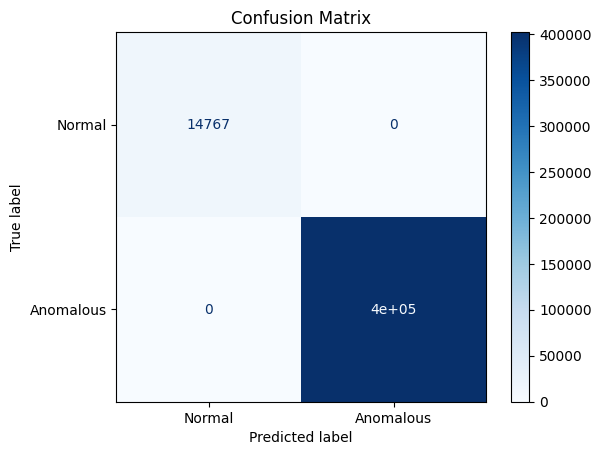

In [17]:
def calculate_accuracy(predictions, true_values, threshold=0.9):
    errors = np.mean((predictions - true_values) ** 2, axis=(1, 2))
    accuracy = np.mean(errors < threshold)
    return accuracy

def plot_confusion_matrix(predictions, true_values, threshold=0.9):
    errors = np.mean((predictions - true_values) ** 2, axis=(1, 2))
    true_labels = (errors < threshold).astype(int)
    predicted_labels = (errors < threshold).astype(int)  # Assuming predictions match true_labels format for demonstration

    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalous"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

predictions, true_values = predict(model, test_dataloader)
accuracy = calculate_accuracy(predictions, true_values)
print(f"Model Accuracy on Test Data: {accuracy * 100:.2f}%")
plot_confusion_matrix(predictions, true_values)

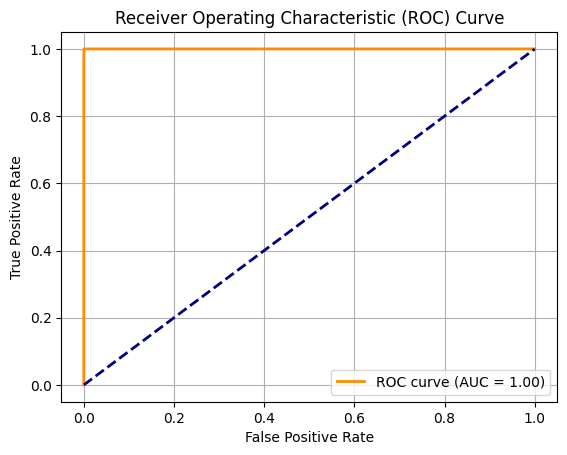

In [13]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(predictions, true_values):
    errors = np.mean((predictions - true_values) ** 2, axis=(1, 2))
    true_labels = (errors < 0.9).astype(int)  # Threshold for determining anomaly
    fpr, tpr, _ = roc_curve(true_labels, -errors)  # Use negative errors for ROC
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

plot_roc_auc(predictions, true_values)

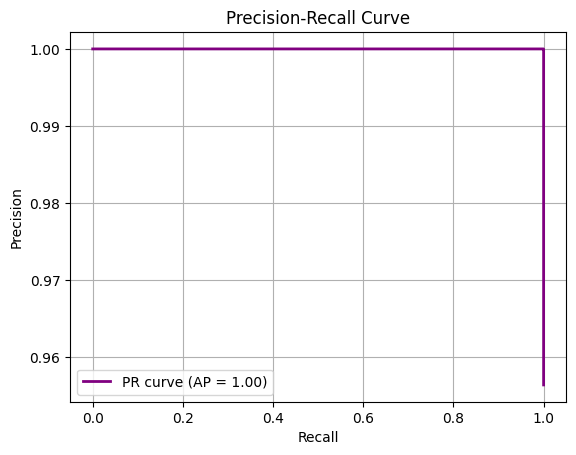

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score
def plot_precision_recall(predictions, true_values):
    errors = np.mean((predictions - true_values) ** 2, axis=(1, 2))
    true_labels = (errors < 0.8).astype(int)
    precision, recall, _ = precision_recall_curve(true_labels, -errors)
    avg_precision = average_precision_score(true_labels, -errors)

    plt.figure()
    plt.plot(recall, precision, color='purple', lw=2, label=f"PR curve (AP = {avg_precision:.2f})")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

plot_precision_recall(predictions, true_values)

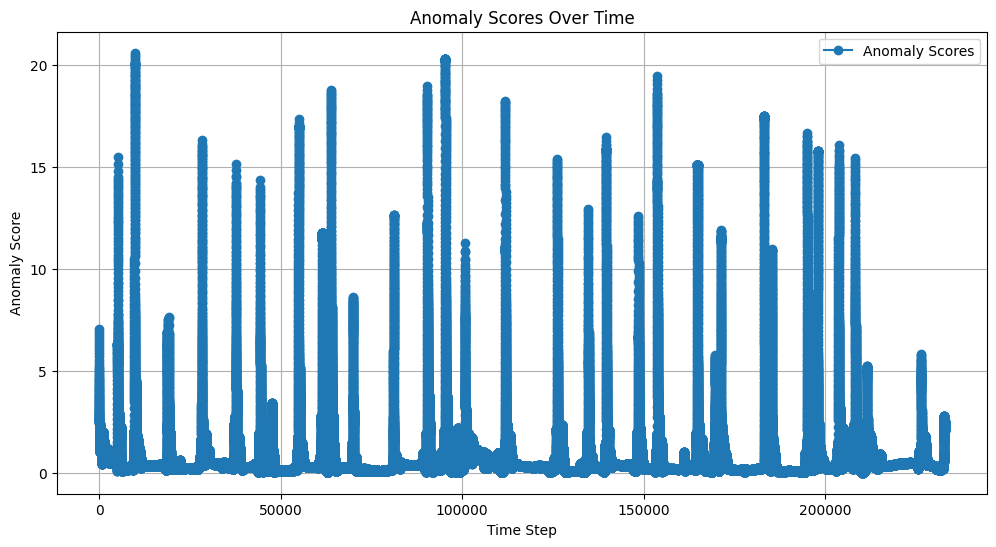

In [17]:
def plot_anomaly_scores_over_time(predictions):
    anomaly_scores = np.mean(predictions ** 2, axis=(1, 2))  # Mean squared anomaly scores per sequence
    plt.figure(figsize=(12, 6))
    plt.plot(anomaly_scores, marker='o', linestyle='-', label='Anomaly Scores')
    plt.xlabel('Time Step')
    plt.ylabel('Anomaly Score')
    plt.title('Anomaly Scores Over Time')
    plt.legend()
    plt.grid()
    plt.show()

plot_anomaly_scores_over_time(predictions)